In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pre_processing import load_and_clean_data
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

In [17]:
#df = pd.read_csv("diabetes_prediction_dataset.csv")

In [2]:
#print(df.shape)       
#print(df.dtypes)        
#print(df.head()) 

In [3]:
# Check for the Duplicates
#n_dup = df.duplicated().sum()
#print("Duplicated Number:", n_dup)

# Check for the missing value
#miss_cnt = df.isna().sum()
#miss_pct = (df.isna().mean() * 100).round(2)
#print("\nNumber of missing value:\n", miss_cnt)
#print("\nMissing value proportion:\n", miss_pct)

# 3. Check for the distributions:
#print("\nGender distribution:\n", df['gender'].value_counts(dropna=False))
#print("\nSmoking_history distribution:\n", df['smoking_history'].value_counts(dropna=False))

#print("\nage: \n", df['age'].describe())
#print("\nbmi: \n", df['bmi'].describe())
#print("\nHbA1c_level: \n", df['HbA1c_level'].describe())
#print("\nblood_glucose_level: \n", df['blood_glucose_level'].describe())


In [5]:
#1.1 eliminate duplicates
df = df.drop_duplicates()

#1.2 remove gender = other
df = df[df['gender'] != 'Other'].reset_index(drop=True)

gender_encoder = LabelEncoder()
df['gender'] = gender_encoder.fit_transform(df['gender'])

#1.2 replace Smoking_History: No Info to NAN
df['smoking_history'] = df['smoking_history'].replace('No Info', np.nan)

#grouping
df['smoking_history'] = df['smoking_history'].replace({ 'ever':    'former', 'not current': 'former'})

df['smoking_history'] = df['smoking_history'].fillna('Unknown')

smoking_history_encoder = LabelEncoder()
df['smoking_history'] = smoking_history_encoder.fit_transform(df['smoking_history'])




In [19]:
X_train, X_val, X_test, y_train, y_val, y_test = load_and_clean_data(
    "diabetes_prediction_dataset.csv", split=True
)

In [20]:
numeric_cols = ['age','bmi','HbA1c_level','blood_glucose_level']
outlier_counts = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (df[col] < lower) | (df[col] > upper)
    outlier_counts[col] = mask.sum()

print("Outliner number: ", outlier_counts)
print("Outliner proportion: ", {col:cnt/len(df)*100  for col,cnt in outlier_counts.items()})

Outliner number:  {'age': 0, 'bmi': 7086, 'HbA1c_level': 1315, 'blood_glucose_level': 2038}
Outliner proportion:  {'age': 0.0, 'bmi': 7.086, 'HbA1c_level': 1.315, 'blood_glucose_level': 2.038}


In [12]:
#feature_cols = ['gender','smoking_history','age','hypertension','heart_disease','bmi','HbA1c_level','blood_glucose_level']
#X = df[feature_cols]
#y = df['diabetes']


In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

#sss = StratifiedShuffleSplit(
#    n_splits=1,     
#    test_size=0.2
#)

#for train_idx, test_idx in sss.split(X, y):
#    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Check the proportion
#print("Oringinal proportion: ", y.mean())
#print("Training set proportion: ", y_train.mean())
#print("Testing set proportion: ", y_test.mean())

In [24]:
#print("Training set size: ", X_train.shape, "Testing set size: ", X_test.shape)

In [27]:
# Define param grid
param_dist = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [{0:1, 1:5}, {0:1, 1:10}, {0:1, 1:15}]
}
# Scorer focused on class 1 (diabetes)
f1_minority = make_scorer(f1_score, pos_label=1)

# Random Forest setup
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [28]:
# Randomized search
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,  # Number of random combinations to try
    scoring=f1_minority,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
# Results
print("Best parameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

In [21]:
# Build the Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=22,
    min_samples_leaf=8,
    random_state=42,
    n_jobs=-1,
    class_weight={0: 1, 1: 10}  # Boost minority class importance
)

In [22]:
#fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=22,
                       min_samples_leaf=8, n_estimators=1000, n_jobs=-1,
                       random_state=42)

              precision    recall  f1-score   support

           0       1.00      0.83      0.90     17534
           1       0.35      0.97      0.52      1696

    accuracy                           0.84     19230
   macro avg       0.67      0.90      0.71     19230
weighted avg       0.94      0.84      0.87     19230

ROC AUC: 0.9746596941844525


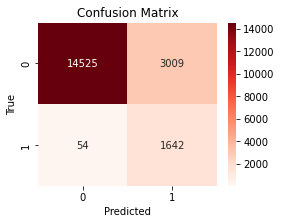

In [23]:
# Do the prediction
y_pred = rf.predict(X_test)

y_proba = rf.predict_proba(X_test)[:, 1]

# Output the classification report
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
"""
for depth in range(1, 30):

    rf = RandomForestClassifier(
    n_estimators = 1000,    
    max_depth = depth,    
    min_samples_leaf = 8,  
    random_state = None,
    n_jobs = -1 ,           
    class_weight = 'balanced')
    
    scores = cross_val_score(rf, X_train, y_train, cv=5) 
    print(f" Depth: {depth}, Average accuracy: {scores.mean():.4f}")
"""

'\nfor depth in range(1, 30):\n\n    rf = RandomForestClassifier(\n    n_estimators = 1000,    \n    max_depth = depth,    \n    min_samples_leaf = 8,  \n    random_state = None,\n    n_jobs = -1 ,           \n    class_weight = \'balanced\')\n    \n    scores = cross_val_score(rf, X_train, y_train, cv=5) \n    print(f" Depth: {depth}, Average accuracy: {scores.mean():.4f}")\n'

Best Parameter: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
Best recall rate: 0.6475036438995749
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     17530
           1       0.79      0.66      0.72      1696

    accuracy                           0.95     19226
   macro avg       0.88      0.82      0.85     19226
weighted avg       0.95      0.95      0.95     19226

ROC AUC: 0.8801171374678447


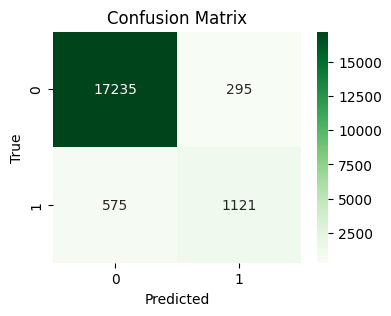

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold


# Pipeline construction
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Grid search for good parameter
param_grid = {
    'knn__n_neighbors': [3,5,7,9,11,13],
    'knn__weights': ['uniform','distance'],
    'knn__p': [1,2]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=skf, scoring='recall', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameter:", grid.best_params_)
print("Best recall rate:", grid.best_score_)

best_knn = grid.best_estimator_
y_pred  = best_knn.predict(X_test)
y_proba = best_knn.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()